✅ Dataset Loaded: (35064, 37)
Sequences → (35040, 24, 36) (35040, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,801 (362.50 KB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0160 - mae: 0.0930 - val_loss: 0.0066 - val_mae: 0.0664
Epoch 2/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035 - mae: 0.0461 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 3/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026 - mae: 0.0392 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 4/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0020 - mae: 0.0350 - val_loss: 0.0015 - val_mae: 0.0304
Epoch 5/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018 - mae: 0.0327 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 6/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 7/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - mae: 0.0289 - val_loss: 0.0026 - val_mae: 0.0409
Epoch 8/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 9/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lo

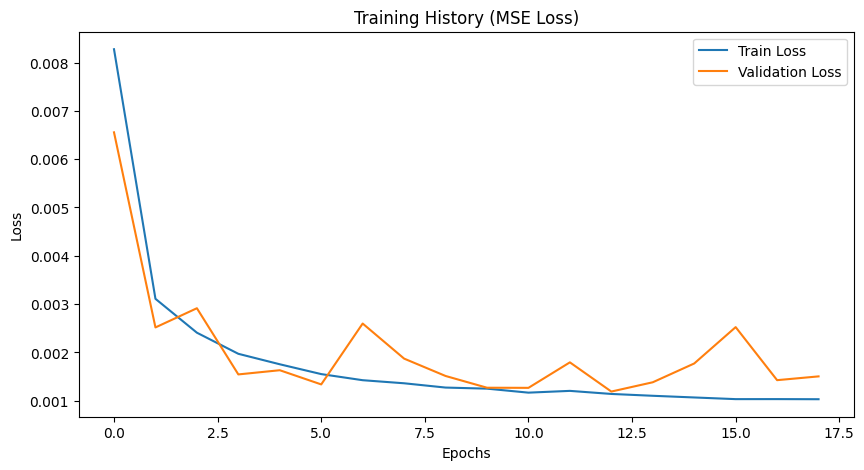

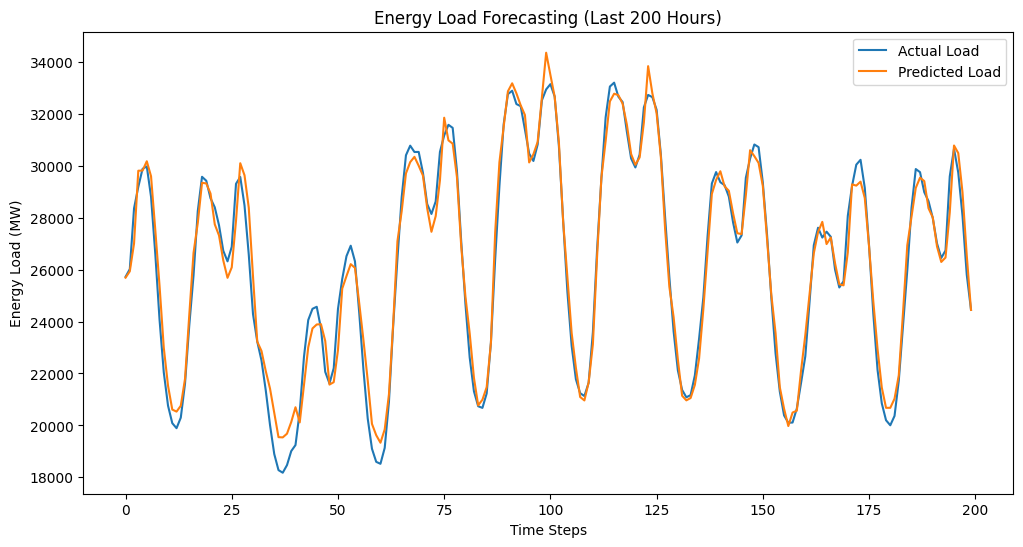


✅ Model and scalers saved successfully!


In [1]:
# ==============================================
# ENERGY CONSUMPTION FORECASTING USING LSTM (AI)
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# ---- Load Dataset ----
df = pd.read_csv("/combined_energy_power_dataset.csv", index_col=0, parse_dates=True)
print("✅ Dataset Loaded:", df.shape)

# ---- Choose Target ----
target_col = "total load actual"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found!")

X = df.drop(columns=[target_col])
y = df[[target_col]]

# ---- Scale Data ----
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# ---- Create Sequences ----
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)
print("Sequences →", X_seq.shape, y_seq.shape)

# ---- Split Train/Test ----
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# ---- Build LSTM ----
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ---- Train Model ----
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# ---- Evaluate ----
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_inv = target_scaler.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
print(f"\n✅ Model Evaluation:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

# ---- Plot Training ----
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History (MSE Loss)')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.show()

# ---- Plot Predictions ----
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[-200:], label='Actual Load')
plt.plot(y_pred[-200:], label='Predicted Load')
plt.title('Energy Load Forecasting (Last 200 Hours)')
plt.xlabel('Time Steps'); plt.ylabel('Energy Load (MW)')
plt.legend(); plt.show()

# ---- Save Model and Scalers ----
model.save("/content/energy_forecast_model.h5")
joblib.dump(feature_scaler, "/content/feature_scaler.pkl")
joblib.dump(target_scaler, "/content/target_scaler.pkl")
print("\n✅ Model and scalers saved successfully!")



✅ MODEL PERFORMANCE METRICS
RMSE (Root Mean Squared Error): 682.612
MAE  (Mean Absolute Error):     509.118
R² Score:                       0.977
Explained Variance Score:       0.977
MAPE (Mean Abs % Error):        1.77%
Approx. Model Accuracy:         98.23%


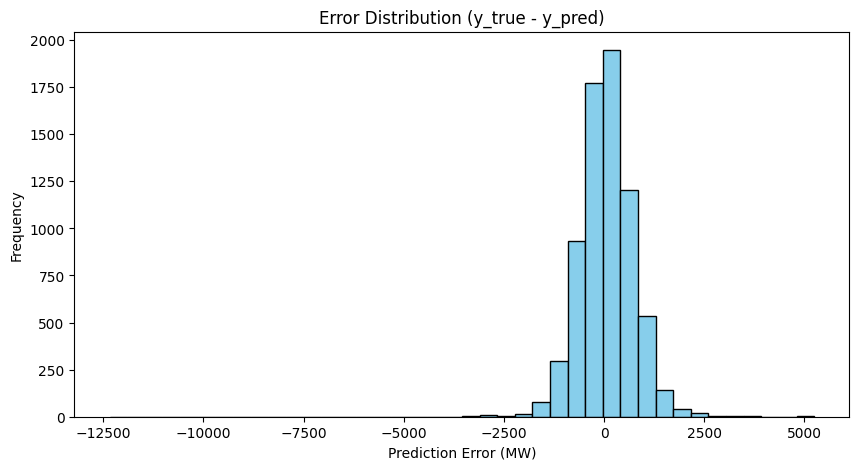

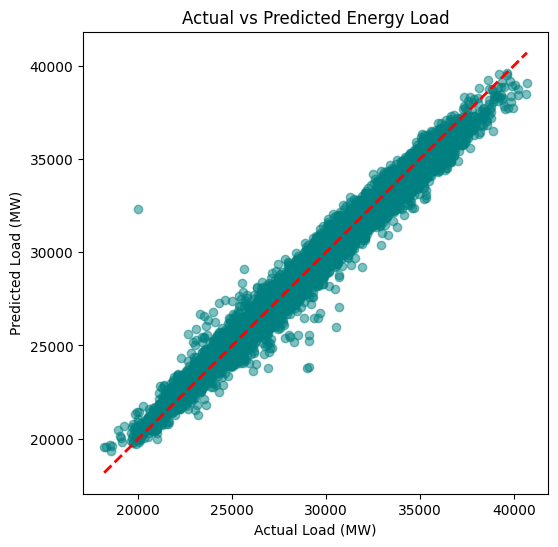

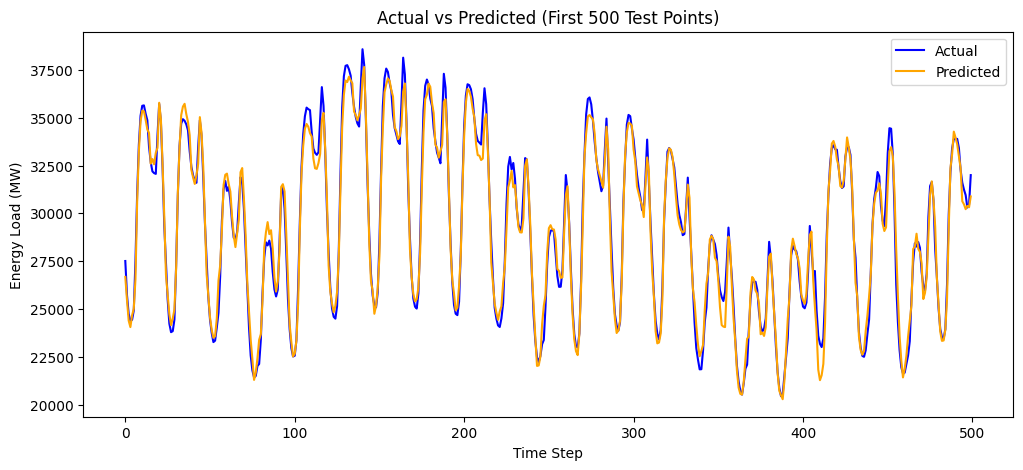

In [2]:
# ==============================================
# 🔍 MODEL EVALUATION - EXTENDED METRICS
# ==============================================

from sklearn.metrics import r2_score, explained_variance_score

# --- Calculate All Metrics ---
rmse = sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)
evs = explained_variance_score(y_test_inv, y_pred)
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100

# Accuracy as (100 - MAPE)
accuracy = 100 - mape

# --- Print Results ---
print("\n✅ MODEL PERFORMANCE METRICS")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"MAE  (Mean Absolute Error):     {mae:.3f}")
print(f"R² Score:                       {r2:.3f}")
print(f"Explained Variance Score:       {evs:.3f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")
print(f"Approx. Model Accuracy:         {accuracy:.2f}%")

# --- Error Analysis ---
errors = y_test_inv - y_pred
plt.figure(figsize=(10,5))
plt.hist(errors, bins=40, color='skyblue', edgecolor='black')
plt.title("Error Distribution (y_true - y_pred)")
plt.xlabel("Prediction Error (MW)")
plt.ylabel("Frequency")
plt.show()

# --- Scatter Plot (Actual vs Predicted) ---
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred, alpha=0.5, color='teal')
plt.title("Actual vs Predicted Energy Load")
plt.xlabel("Actual Load (MW)")
plt.ylabel("Predicted Load (MW)")
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         'r--', lw=2)
plt.show()

# --- Line Comparison Plot (Full Test Set) ---
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:500], label="Actual", color='blue')
plt.plot(y_pred[:500], label="Predicted", color='orange')
plt.title("Actual vs Predicted (First 500 Test Points)")
plt.xlabel("Time Step")
plt.ylabel("Energy Load (MW)")
plt.legend()
plt.show()


In [3]:
model.save("energy_forecast_model.h5")
import joblib
joblib.dump(feature_scaler, "feature_scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")

print("✅ Model and scalers saved successfully!")


✅ Model and scalers saved successfully!


In [5]:
from google.colab import files
files.download("energy_forecast_model.h5")
files.download("feature_scaler.pkl")
files.download("target_scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import tensorflow as tf
import tf2onnx

# Load model (without compile)
model = tf.keras.models.load_model("energy_forecast_model.h5", compile=False)

# Create a sample input (adjust to match your model’s input shape)
spec = (tf.TensorSpec((1, 24, model.input_shape[2]), tf.float32, name="input"),)

# Convert to ONNX via TensorFlow function tracing
output_path = "energy_forecast_model.onnx"
model_proto, _ = tf2onnx.convert.from_function(
    tf.function(model),
    input_signature=spec,
    opset=17,
    output_path=output_path
)

print(f"✅ Model successfully converted and saved to: {output_path}")



ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7f91da78ce00>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:Tensorflow op [sequential_1/lstm_1/CudnnRNNV3: CudnnRNNV3] is not supported
ERROR:tf2onnx.tfonnx:Unsupported ops: Counter({'CudnnRNNV3': 1})


✅ Model successfully converted and saved to: energy_forecast_model.onnx


In [15]:
from google.colab import files
files.download("energy_forecast_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>